# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
15974,23233,68185,"New York, NY USA",24-03-2020,What are 10 emerging cross-industry #trends th...,Negative
5118,10020,54972,"St.Petersburg, Florida",19-03-2020,As concerns about the #coronavirus pandemic co...,Extremely Positive
3895,8526,53478,"guelph, ontario",18-03-2020,Don't panic. There's enough food. @ElizabethMa...,Negative
24043,33187,78139,United States,05-04-2020,WeÃÂve been trying to minimize grocery trips...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
# Для начала посмотрим, какие значения есть у целевой переменной
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
# Теперь преобразуем
df['Sentiment'] = df['Sentiment'].apply(lambda s: 1 if "Positive" in s else 0)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30572,41392,86344,"Bingley, England",10-04-2020,Blue in the Supermarket Queue\r\r\nIt's so str...,0
1982,6215,51167,NaN,17-03-2020,what is the Trump administration doing to hel...,1
7443,12840,57792,NaN,20-03-2020,"For the first time in life, the winner will be...",1
963,4960,49912,Yorkshire and The Humber,17-03-2020,Parents told to self isolate as both are at ri...,0


Сбалансированы ли классы?

In [ ]:
print(df['Sentiment'].value_counts(normalize=True))

Sentiment
1    0.539589
0    0.460411
Name: proportion, dtype: float64


**Ответ:** Да, классы сбалансированы, доля обоих близка к 50%




Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
# Выведем информацию о пропусках в данных
print(df.isnull().sum())

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [ ]:
# Заполним пропуски
df.fillna('Unknown', inplace=True)
print(df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
# Для подсчета
from collections import Counter

In [ ]:
all_tokens = []
for tweet in train['OriginalTweet']:
  all_tokens.extend(tweet.lower().split())

token_counts = Counter(all_tokens)

Какой размер словаря получился?

In [ ]:
print(len(token_counts))

79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
print(token_counts.most_common(10))

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


**Ответ:** 9 из 10 - предлоги, союзы и артикли - неотъемлимая часть почти любого предложения, независимо от его смысла. Еще один - хэштег #coronavirus - тоже максимально ожидаемая часть твитов про коронавирус.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

filtered_tokens = {token: count for token, count in token_counts.items() if token not in stopwords.words('english')}

filtered_token_counts = Counter(filtered_tokens)

print(filtered_token_counts.most_common(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223), ('prices', 3891), ('food', 3820), ('grocery', 3469), ('supermarket', 3288), ('people', 3175), ('covid-19', 3173), ('store', 3155), ('#covid19', 2471), ('&amp;', 2314)]


**Ответ:**  Кажется, во время ковида люди были очень озабочены ценами на еду в супермаркетах



Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
# Для подсчета просто инвертируем список самых популярных слов
print(filtered_token_counts.most_common()[:-21:-1])

[('https://t.co/7j2y3rsld9', 1), ('@680news', 1), ('@torontopearson', 1), ('nothing...', 1), ('flew', 1), ('wage!', 1), ('renewing', 1), ('playersã\x82â\x92', 1), ('subsidise', 1), ('non-playing', 1), ('premiership', 1), ('https://t.co/iaek4fwsgz', 1), ('@srinivasiyc', 1), ('https://t.co/zjcl195vqs', 1), ('#southkerry', 1), ('#skelligcoast2kms', 1), ('@skelligsix18', 1), ('closer!)', 1), ('coast!', 1), ('skellig', 1)]


**Ответ:** это различные ссылки и тэги - они уникальны по своей природе, поэтому понятно, почему они возникают буквально по одному разу. Я думаю, что они не нуждаются в дополнительной обработке, однако, если мы посчитаем, что для нашего исследования слишком много признаков - мы сможем их удалить



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

tweet_tokens = []
for tweet in train['OriginalTweet']:
    tokens = tokenizer.tokenize(tweet)
    tweet_tokens.extend([token.lower() for token in tokens])

tweet_token_counts = Counter(tweet_tokens)

print(tweet_token_counts.most_common(10))

[('the', 26993), ('.', 24118), ('to', 23478), (',', 17571), ('and', 14825), ('of', 13044), ('a', 11891), ('in', 11348), ('?', 9524), ('#coronavirus', 8808)]


**Ответ:** Здесь присутствуют знаки препинания, что важно для твитов - ведь сами знаки преминания показывают очень много экспресси в коротких сообщениях, а также знаки препинания - часть смайликов) (а они тоже очень часто используются в твитах)

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

filtered_tweet_tokens = {token: count for token, count in tweet_token_counts.items() if token not in stopwords.words('english') and token not in punctuation}

filtered_tweet_token_counts = Counter(filtered_tweet_tokens)

print(filtered_tweet_token_counts.most_common(10))

[('#coronavirus', 8808), ('â', 7415), ('\x82', 7311), ('19', 7167), ('covid', 6253), ('prices', 4601), ('\x92', 4372), ('food', 4367), ('store', 3877), ('supermarket', 3805)]


**Ответ:** Да, это токены вида \x82 и \x92 - судя по гуглу, это символы кавычек

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
unicode_filtered_tweet_tokens = {token: count for token, count in filtered_tweet_token_counts.items() if len(token) > 1 or ord(token[0]) < 128}

unicode_filtered_tweet_token_counts = Counter(unicode_filtered_tweet_tokens)

print('Popular:', unicode_filtered_tweet_token_counts.most_common(10))

print('Unpopular:', unicode_filtered_tweet_token_counts.most_common()[:-21:-1])

Popular: [('#coronavirus', 8808), ('19', 7167), ('covid', 6253), ('prices', 4601), ('food', 4367), ('store', 3877), ('supermarket', 3805), ('grocery', 3523), ('people', 3463), ('#covid19', 2589)]
Unpopular: [('https://t.co/7j2y3rsld9', 1), ('@680news', 1), ('@torontopearson', 1), ('flew', 1), ('renewing', 1), ('playersã', 1), ('subsidise', 1), ('non-playing', 1), ('premiership', 1), ('https://t.co/iaek4fwsgz', 1), ('@srinivasiyc', 1), ('https://t.co/zjcl195vqs', 1), ('#southkerry', 1), ('#skelligcoast2kms', 1), ('@skelligsix18', 1), ('skellig', 1), ('milion', 1), ('now.when', 1), ('https://t.co/5cbliqzx7l', 1), ('https://t.co/lw1r0rm7xs', 1)]


**Ответ:** я бы сказала, что они в целом дают очень похожие результаты. В популярных - речь о еде, супермаркетах, магазинах, ценах и бакалее - вероятно, для покупки "стратегических запасов". В самых непопулярных - снова ссылки и теги

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
hashtags = {token: count for token, count in unicode_filtered_tweet_token_counts.items() if token.startswith('#')}

hashtag_counts = Counter(hashtags)

print(hashtag_counts.most_common(10))

[('#coronavirus', 8808), ('#covid19', 2589), ('#covid_19', 1734), ('#covid2019', 946), ('#toiletpaper', 744), ('#covid', 641), ('#socialdistancing', 465), ('#coronacrisis', 448), ('#pandemic', 257), ('#coronaviruspandemic', 249)]


**Ответ:** В целом, хэштеги выполняют свою обычную функцию - помечают твит нужной тематикой (в данном случае - ковид) для его продвижения. Большинство - разные вариации названия крорнавируса, но было интересно встретить на 5-м месте мемный хэштег про туалетную бумагу (которую люди тогда закупали)) Это говорит о том, что люди даже в тяжелое время стремятся пошутить)


То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
t_links = {token: count for token, count in unicode_filtered_tweet_token_counts.items() if token.startswith('https://t.co')}

t_links_counts = Counter(t_links)

print(t_links_counts.most_common(10))

[('https://t.co/oxa7swtond', 5), ('https://t.co/gp3eusapl8', 4), ('https://t.co/deftrui1pfã\x82â', 3), ('https://t.co/wrlhyzizaa', 3), ('https://t.co/kuwipf1kqw', 3), ('https://t.co/zjnrx6dkkn', 3), ('https://t.co/3gbbdpdjat', 3), ('https://t.co/e2znxajpre', 3), ('https://t.co/catkegayoy', 3), ('https://t.co/g63rp042ho', 3)]


**Ответ:** я дцмаю, в данном случае популярность ссылок не сравнима с популярностью хэштегов. Самая популярная ссылка имеет всего 5 упоминаний - это совершенно не сравнится с сотнями и тысячами упоминаний хэштегов. Думаю, в данном случае, информация о ссылках нам не будет полезна вследствие их непопулярности, но не исключаю, что в других кейсах ссылки могли бы быть более популярны и ползены

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):
  # Подготовка утилит
  tweet_tokenizer = TweetTokenizer()

  # Текст к нижнему регистру
  text = text.lower()

  # TweetTokenizer для изначального выделения токенов
  tokens = tweet_tokenizer.tokenize(text)

  # Фильтруем
  filtered_tokens = [
      token for token in tokens
      if token not in stopwords.words('english')
      and token not in punctuation
      and (len(token) > 1 or ord(token[0]) < 128)
      and not token.startswith('http://t.co')
      and not token.startswith('https://t.co')
  ]

  return filtered_tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** уменьшился почти в два раза

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
# Выделим твит для удобства
tweet = train.iloc[ind]['OriginalTweet']

# Применим наш векторайзер
tweet_vector = cv.transform([tweet]).toarray()

# Cамый важный токен
max_index = tweet_vector.argmax()
max_token = [token for token, index in cv.vocabulary_.items() if index == max_index][0]
max_value = tweet_vector[0, max_index]

# Cамый неважный токен
# Выделим все ненулевые элементы
non_zero_indices = tweet_vector.nonzero()[1]
min_index = non_zero_indices[tweet_vector[0, non_zero_indices].argmin()]
min_token = [token for token, index in cv.vocabulary_.items() if index == min_index][0]
min_value = tweet_vector[0, min_index]

print("Самый важный токен:", max_token, "со значением:", max_value)
print("Самый неважный токен:", min_token, "со значением:", min_value)

Самый важный токен: #coronavirusoutbreak со значением: 1
Самый неважный токен: #coronavirusoutbreak со значением: 1


**Ответ:** Результат не информативен, так как каждое слово в нашем твите встречается не более олного раза. По сути сейчас мы имеем булевую табличку присутствия слов в твите

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторайзер
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

# Обучаем
tfidf.fit(train['OriginalTweet'])

TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x7c86e3c36b90>)

In [ ]:
# Применяем к конкретному твиту
tweet_text = train.iloc[ind]['OriginalTweet']
tweet_vector = tfidf.transform([tweet_text]).toarray()

# Cамый важный токен
max_index = tweet_vector.argmax()
max_token = [token for token, index in tfidf.vocabulary_.items() if index == max_index][0]
max_value = tweet_vector[0, max_index]

# Cамый неважный токен
# Выделим все ненулевые элементы
non_zero_indices = tweet_vector.nonzero()[1]
min_index = non_zero_indices[tweet_vector[0, non_zero_indices].argmin()]
min_token = [token for token, index in tfidf.vocabulary_.items() if index == min_index][0]
min_value = tweet_vector[0, min_index]

print("Самый важный токен:", max_token, "со значением TF-IDF:", max_value)
print("Самый неважный токен:", min_token, "со значением TF-IDF:", min_value)

Самый важный токен: brainless со значением TF-IDF: 0.3867641170466375
Самый неважный токен: food со значением TF-IDF: 0.11328893069250721


**Ответ:** Думаю, самый важный токен определился хорошо - 'brainless' действительно хорошо показывает негативную окраску. Самый неважный токен - 'food' - довольно нетрален по эмоциональной окраске, поэтому, кажется, самый низкий коэффициент у него в целом справедлив

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
4066,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÃÂre giving supermarkets the opt...,1
342,4219,49171,"Boston, MA",16-03-2020,[THREAD] China's role in wildlife trade should...,1
21883,30511,75463,London,02-04-2020,Coronavirus career pivots: 'I now work in a su...,1
23519,32529,77481,"Moulton, England",05-04-2020,Well done James great front of store before we...,1
...,...,...,...,...,...,...
21960,30608,75560,Unknown,02-04-2020,@dino_melaye I commend your efforts so far in ...,1
23905,33018,77970,Unknown,05-04-2020,Absolutely brilliant idea amp a great use of a...,1
25907,35528,80480,Bay Area,07-04-2020,Afraid of tracking in the #coronavirus? Here a...,1
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1


In [ ]:
good_ind = 4

good_tweet = train.iloc[good_ind]['OriginalTweet']
print(good_tweet)

Finally got to the grocery store. Honestly, what are you people doing with all the toilet paper? #coronavirus https://t.co/JmoBv8z0U0


In [ ]:
# Применяем к конкретному твиту
tweet_text = train.iloc[good_ind]['OriginalTweet']
tweet_vector = tfidf.transform([tweet_text]).toarray()

# Cамый важный токен
max_index = tweet_vector.argmax()
max_token = [token for token, index in tfidf.vocabulary_.items() if index == max_index][0]
max_value = tweet_vector[0, max_index]

# Cамый неважный токен
# Выделим все ненулевые элементы
non_zero_indices = tweet_vector.nonzero()[1]
min_index = non_zero_indices[tweet_vector[0, non_zero_indices].argmin()]
min_token = [token for token, index in tfidf.vocabulary_.items() if index == min_index][0]
min_value = tweet_vector[0, min_index]

print("Самый важный токен:", max_token, "со значением TF-IDF:", max_value)
print("Самый неважный токен:", min_token, "со значением TF-IDF:", min_value)

Самый важный токен: honestly со значением TF-IDF: 0.5402242668106653
Самый неважный токен: #coronavirus со значением TF-IDF: 0.1427209845055056


**Ответ:** Это похоже на шутку и тот самый мем про туалетную бумагу, поэтому у него положительная окраска

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
count_matrix = cv.fit_transform(train['OriginalTweet'])
tfidf_matrix = tfidf.fit_transform(train['OriginalTweet'])

# Выделим целевую переменную
y_train = train['Sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Снова разделим данные на обучающие и тестовые выборки
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(
    count_matrix, y_train, test_size=0.3, random_state=0)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_matrix, y_train, test_size=0.3, random_state=0)

# Регрессия на CountVectorizer данных
model_count = LogisticRegression(max_iter=1000)
model_count.fit(X_train_count, y_train_count)

# Регрессия на TfidfVectorizer данных
model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Предсказания и оценка для CountVectorizer
y_pred_train_count = model_count.predict(X_train_count)
y_pred_test_count = model_count.predict(X_test_count)
accuracy_train_count = accuracy_score(y_train_count, y_pred_train_count)
accuracy_test_count = accuracy_score(y_test_count, y_pred_test_count)

# Предсказания и оценка для TfidfVectorizer
y_pred_train_tfidf = model_tfidf.predict(X_train_tfidf)
y_pred_test_tfidf = model_tfidf.predict(X_test_tfidf)
accuracy_train_tfidf = accuracy_score(y_train_tfidf, y_pred_train_tfidf)
accuracy_test_tfidf = accuracy_score(y_test_tfidf, y_pred_test_tfidf)

# Выведем результаты
print("CountVectorizer - Accuracy на обучающей выборке:", accuracy_train_count)
print("CountVectorizer - Accuracy на тестовой выборке:", accuracy_test_count)
print("TfidfVectorizer - Accuracy на обучающей выборке:", accuracy_train_tfidf)
print("TfidfVectorizer - Accuracy на тестовой выборке:", accuracy_test_tfidf)

CountVectorizer - Accuracy на обучающей выборке: 0.9869408677610301
CountVectorizer - Accuracy на тестовой выборке: 0.862309554321515
TfidfVectorizer - Accuracy на обучающей выборке: 0.9269542930371636
TfidfVectorizer - Accuracy на тестовой выборке: 0.8352555887797237


**Ответ:** Оба векторайзера показали неплохие результаты. На тестовых данных они показали себя практически одинаково

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [ ]:
def custom_stem_tokenizer(text):
  # Подготовка утилит
  tweet_tokenizer = TweetTokenizer()

  # Текст к нижнему регистру
  text = text.lower()

  # TweetTokenizer для изначального выделения токенов
  tokens = tweet_tokenizer.tokenize(text)

  # Фильтруем
  filtered_tokens = [
      token for token in tokens
      if token not in stopwords.words('english')
      and token not in punctuation
      and (len(token) > 1 or ord(token[0]) < 128)
      and not token.startswith('http://t.co')
      and not token.startswith('https://t.co')
  ]

  # Добавим стэмминг
  stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

  return stemmed_tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

cv_matrix = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [ ]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

tfidf_matrix = tfidf.fit_transform(train['OriginalTweet'])

print(len(tfidf.vocabulary_))

36652


**Ответ:** Выборка уменьшилась более, чем в два раза.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
# Снова разделим данные на обучающие и тестовые выборки
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(cv_matrix, train['Sentiment'], test_size=0.3, random_state=0)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, train['Sentiment'], test_size=0.3, random_state=0)

# Регрессия на CountVectorizer данных
model_count = LogisticRegression(max_iter=1000)
model_count.fit(X_train_count, y_train_count)

# Регрессия на TfidfVectorizer данных
model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Предсказания и оценка для CountVectorizer
y_pred_train_count = model_count.predict(X_train_count)
y_pred_test_count = model_count.predict(X_test_count)
accuracy_train_count = accuracy_score(y_train_count, y_pred_train_count)
accuracy_test_count = accuracy_score(y_test_count, y_pred_test_count)

# Предсказания и оценка для TfidfVectorizer
y_pred_train_tfidf = model_tfidf.predict(X_train_tfidf)
y_pred_test_tfidf = model_tfidf.predict(X_test_tfidf)
accuracy_train_tfidf = accuracy_score(y_train_tfidf, y_pred_train_tfidf)
accuracy_test_tfidf = accuracy_score(y_test_tfidf, y_pred_test_tfidf)

# Выведем результаты
print("CountVectorizer with Stemming - Accuracy на обучающей выборке:", accuracy_train_count)
print("CountVectorizer with Stemming - Accuracy на тестовой выборке:", accuracy_test_count)
print("TfidfVectorizer with Stemming - Accuracy на обучающей выборке:", accuracy_train_tfidf)
print("TfidfVectorizer with Stemming - Accuracy на тестовой выборке:", accuracy_test_tfidf)

CountVectorizer with Stemming - Accuracy на обучающей выборке: 0.9779093183621164
CountVectorizer with Stemming - Accuracy на тестовой выборке: 0.8600313256443115
TfidfVectorizer with Stemming - Accuracy на обучающей выборке: 0.9179837676206749
TfidfVectorizer with Stemming - Accuracy на тестовой выборке: 0.8450804499501637


**Ответ:** Кажется, что значительных улучшений нет - только на тестовой выборке для Tfidf качество увеличилось на 1%.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.35).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [ ]:
max_df = 0.35

**Ответ:** Оно довольно небольшое, вероятно потому, что частота употребления слова во всех документах коллекции довольно большая для всех слов (из-за большого количества твитов и не столь широкого словарного запаса для твитов :) )

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00044).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


In [ ]:
best_min_df = 0.00044

# После нахождения оптимального min_df, проверим влияние на качество модели
cv_df_final = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=best_min_df)
X = cv_df_final.fit_transform(train['OriginalTweet'])
y = train['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("min_df:", best_min_df)
print("точность на тестовой выборке:", accuracy)

min_df: 0.00044
точность на тестовой выборке: 0.8546205325359533


**Ответ:** Итак, мы можем уменьшать размер словаря в 10 раз, при этом не теряя в точности модели - это успех) Ну, понятно, это говорит о том, что для понимания смысловой окраски нужны далеко не все слова, а только довольно специфичные для нашего текста

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

Точность модели: 0.8012245479139969
Топ-10 положительных токенов: ['great', 'support', 'pleas', 'posit', 'like', 'help', 'best', 'thank', 'free', 'hand']
Топ-10 отрицательных токенов: ['crisi', 'panic', 'fraud', 'scam', 'kill', 'frighten', 'blame', 'die', 'crude', 'fear']


<ipython-input-45-a775aed0c3d5>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_coefficients], y=[cv_df_final.get_feature_names_out()[i] for i in top_coefficients], palette=colors)


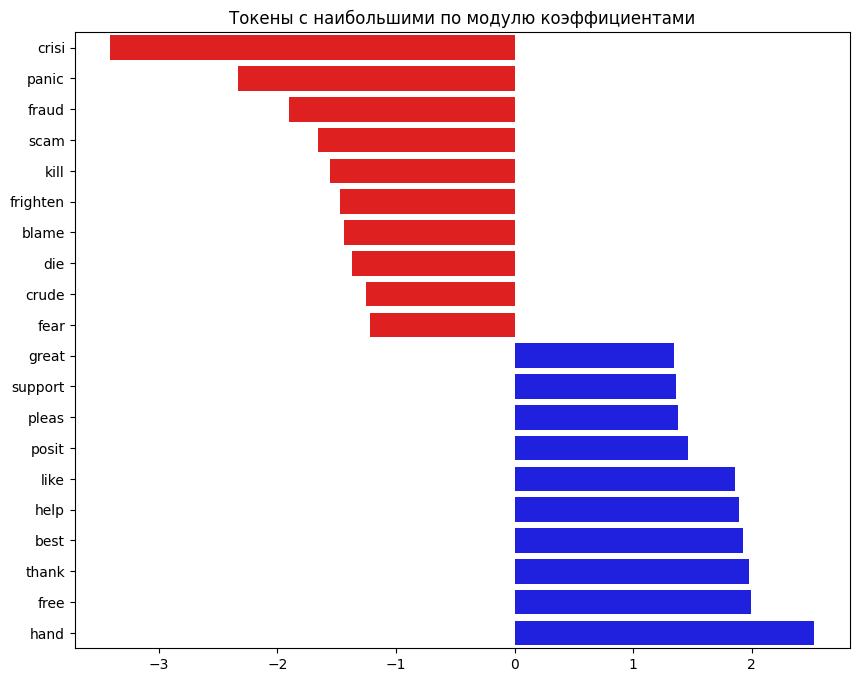

In [ ]:
from sklearn.preprocessing import StandardScaler

# Скалируем
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Оцениваем
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Точность модели:", accuracy)

# Находим топы
feature_importances = model.coef_[0]
top_positive_tokens = np.argsort(feature_importances)[-10:]
top_negative_tokens = np.argsort(feature_importances)[:10]
print("Топ-10 положительных токенов:", [cv_df_final.get_feature_names_out()[i] for i in top_positive_tokens])
print("Топ-10 отрицательных токенов:", [cv_df_final.get_feature_names_out()[i] for i in top_negative_tokens])

# Визуализация
fig, ax = plt.subplots(figsize=(10, 8))
top_coefficients = np.hstack([top_negative_tokens, top_positive_tokens])
colors = ["red" if c < 0 else "blue" for c in feature_importances[top_coefficients]]
sns.barplot(x=feature_importances[top_coefficients], y=[cv_df_final.get_feature_names_out()[i] for i in top_coefficients], palette=colors)
plt.title("Токены с наибольшими по модулю коэффициентами")
plt.show()

**Ответ:** Во-первых, нельзя не отметить ускорение работы после уменьшения словаря, это крайне приятно! Во-вторых, полученные токены начинают казаться очень осмысленными: паника, смерть, кризис, помощь - все действительно актуально

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** Я не считаю эти при полезнымзи в данном контексте. Во-первых, они показывают лишь персонализированные данные, которые вряд ли помогут определить эмоциональную окраску: человек с любым ником мог оставить как позитивный, так и негативный комментарий. Во-вторых, эти данные закодированы в целях сохранения конфиденциальности, так что они имеют еще меньше смысла для нас.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

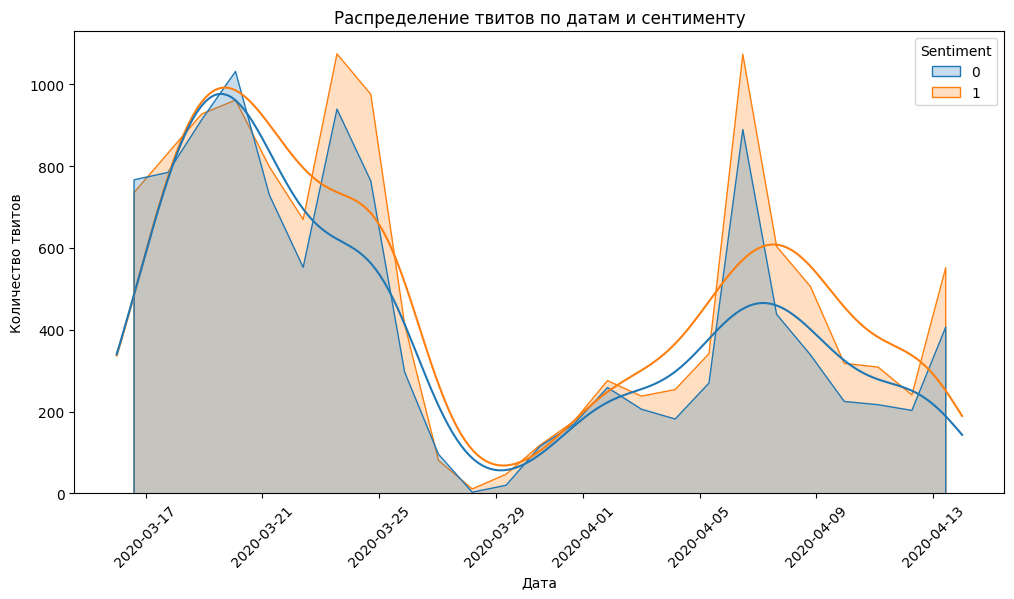

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')

plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', element='poly', kde=True)
plt.title('Распределение твитов по датам и сентименту')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.show()

**Ответ:** Я не считаю, что признак полезен, так как нет ни одной даты, где количество положительный отзывов сильно отличалось от количества отрицательных. В районе 7 апреля число положиетльных отзывов более чем на 10% превысило число отрицательных, но, глядя на остальные дни и почти совпадение чисел в них, я не считаю это основанием использовать дату как признак



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
unique_locations = train['Location'].nunique()

print(f"Количество уникальных местоположений: {unique_locations}")

Количество уникальных местоположений: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<ipython-input-56-ee713a271ecc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


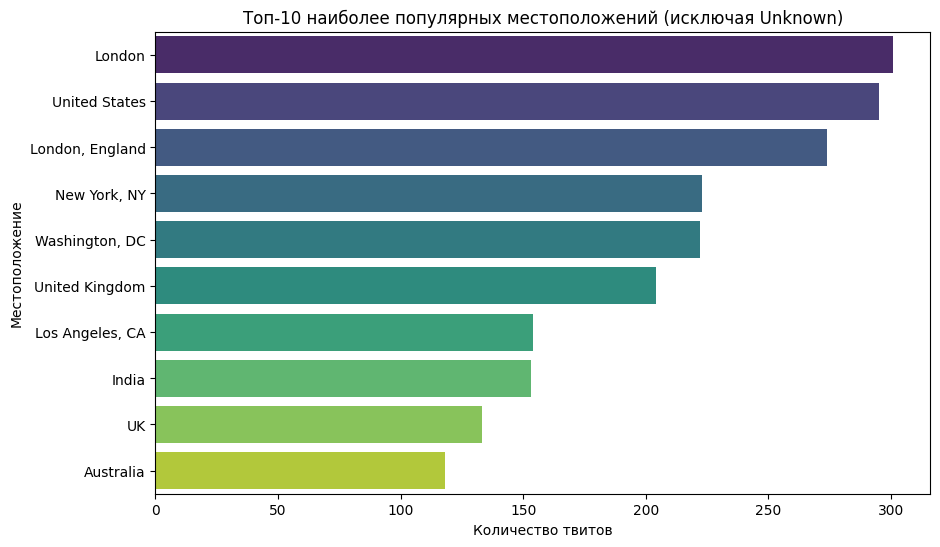

In [ ]:
filtered_locations = train[train['Location'] != 'Unknown']['Location']

top_locations = filtered_locations.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Топ-10 наиболее популярных местоположений (исключая Unknown)')
plt.xlabel('Количество твитов')
plt.ylabel('Местоположение')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else x)

unique_wider_locations = train['WiderLocation'].nunique()
print(f"Количество уникальных широких местоположений: {unique_wider_locations}")

Количество уникальных широких местоположений: 4631


<ipython-input-58-7571aa65b9a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_wider_locations.values, y=top_wider_locations.index, palette='viridis')


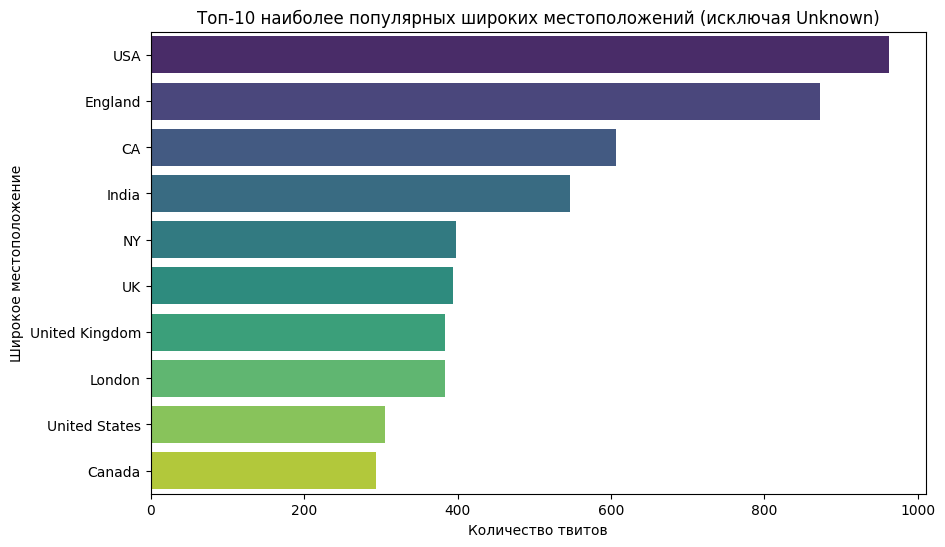

In [ ]:
filtered_wider_locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation']
top_wider_locations = filtered_wider_locations.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_wider_locations.values, y=top_wider_locations.index, palette='viridis')
plt.title('Топ-10 наиболее популярных широких местоположений (исключая Unknown)')
plt.xlabel('Количество твитов')
plt.ylabel('Широкое местоположение')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
location_counts = train['WiderLocation'].value_counts()

locations_more_than_once = location_counts[location_counts > 1].index

print(f"Количество местоположений, встречающихся более одного раза: {len(locations_more_than_once)}")

Количество местоположений, встречающихся более одного раза: 988


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['OriginalTweet'], train['Sentiment'], test_size=0.3, random_state=0)
X_location_train = train.loc[X_train.index, 'WiderLocation']
X_location_test = train.loc[X_test.index, 'WiderLocation']

encoder = OneHotEncoder(handle_unknown='ignore')
X_location_train_encoded = encoder.fit_transform(X_location_train.values.reshape(-1, 1))
X_location_test_encoded = encoder.transform(X_location_test.values.reshape(-1, 1))

X_train_combined = hstack([X_train_scaled, X_location_train_encoded])
X_test_combined = hstack([X_test_scaled, X_location_test_encoded])

model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)

print("Точность модели на тестовой выборке после добавления WiderLocation:", accuracy)

Точность модели на тестовой выборке после добавления WiderLocation: 0.7975224263135412


**Ответ:** Точность модели ухудшилась( Кажется, окраска твитов насчет коронавируса не зависит от месттоположения: люди по всему миру испытывали приблизительно одинаковые эмоции)

## Отзыв по домашке
1. Она прикольная, но такааааая долгая. Долгое обучение, еще и когда перед финальным этапом коллаб решил перезапуститься и пришлось выполнять это все заново...
2. Вообще классно и интересно этим заниматься. Мегалайк! Уставшая, но довольная

![Пример изображения](https://i.pinimg.com/564x/3a/90/b0/3a90b00bd095d61f50b478aaae1da14b.jpg "Это пример изображения")

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --